In [2]:
from mxnet import autograd
from mxnet import ndarray as nd
from mxnet import gluon
import pandas as pd
import numpy as np


In [3]:
#导入 取了对数的label

df_train = pd.read_csv('./input/processed_train_logged.csv')
df_test = pd.read_csv('./input/processed_test_logged.csv')

#导入没有取对数的label

# df_train = pd.read_csv('./input/processed_train_without_log.csv')
# df_test = pd.read_csv('./input/processed_test_without_log.csv')

In [4]:
#处理输入数据
target = 'label'
feat_data = df_train[df_train.columns[df_train.columns!='label']]
feat_names = feat_data.dtypes[feat_data.dtypes!=object].index
train_data = nd.array(df_train[feat_names].values)
label = nd.array(df_train['label'].values)
test_data = nd.array(df_test.values)


In [5]:
def get_rmse_log(net, X_train, y_train):
    num_train = X_train.shape[0]
    clipped_preds = nd.clip(net(X_train), 1, float('inf'))
    return np.sqrt(2 * nd.sum(l2loss(
        nd.log(clipped_preds), nd.log(y_train))).asscalar() / num_train)

In [6]:
#使用gluon内置的dataloader

def get_net():
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Dense(1))
    net.initialize()
    return net

In [7]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

In [8]:
#用一个多层感知机吧
import mxnet.gluon.nn as nn
import mxnet

net = get_net()
# training
global_train_loss = []
l2loss = gluon.loss.L2Loss()
def train_test(net,train_data,train_label,test_data,test_label,learning_rate,wd,epoches,verbose_epoches,batch_size):
    #kfold
    #net 需要重新初始化
    net.collect_params().initialize(force_reinit=True)
    dataset_train = gluon.data.ArrayDataset(train_data, train_label)
    data_iter_train = gluon.data.DataLoader(dataset_train, batch_size,shuffle=True)
    trainer = gluon.Trainer(net.collect_params(),'adam',{'learning_rate':learning_rate,'wd': wd})
    train_loss = []
    test_loss = []
    for epoch in range(epoches):
        
        rmse = 0.0
        for data,label in data_iter_train:
            with autograd.record():
                output = net(data)
                loss = l2loss(output,label)
            loss.backward()
            trainer.step(batch_size)
            cur_train_loss = get_rmse_log(net,train_data,train_label)
        
        
        train_loss.append(cur_train_loss)
        cur_test_loss = get_rmse_log(net,test_data,test_label)
        if(epoch>verbose_epoches):
            print("Epoch:%d, training rmse:%f , testing rmse:%f"%(epoch,cur_train_loss,cur_test_loss))
        test_loss.append(cur_test_loss)
    plt.plot(train_loss)
    plt.legend(['train'])
    plt.plot(test_loss)
    plt.legend(['train','test'])
    plt.show()
    return cur_train_loss,cur_test_loss
    
    



In [9]:
#write k-fold codes
from sklearn.model_selection import KFold

def kfold_crossvalidation(epoches,verbose_epoches,learning_rate,wd,batch_size):
    kf = KFold(n_splits=3)
    valid_rmse_all = []
    for train_index,test_index in kf.split(train_data):
        train_index= nd.array(train_index)
        test_index = nd.array(test_index)
        train_feat,train_label = nd.take(train_data,train_index),nd.take(label,train_index)
        valid_feat,valid_label = nd.take(train_data,test_index),nd.take(label,test_index)
        train_rmse,valid_rmse = train_test(net,train_feat,train_label,valid_feat,valid_label,learning_rate,wd,epoches,verbose_epoches,batch_size)
        valid_rmse_all.append(valid_rmse)
    return np.mean(valid_rmse_all)


Epoch:98, training rmse:0.034628 , testing rmse:0.038981
Epoch:99, training rmse:0.034782 , testing rmse:0.039222


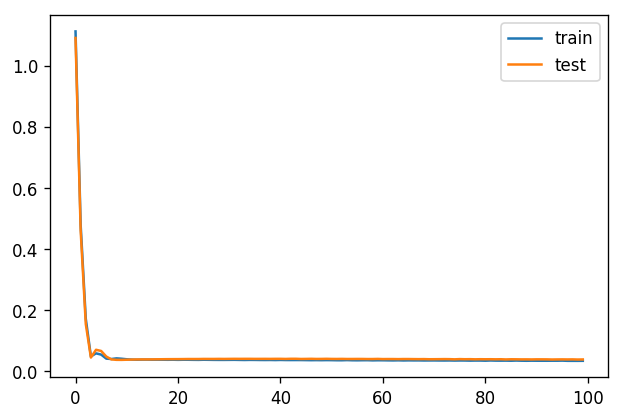

In [ ]:
# tunning parameters

batch_size = 100
epoches = 100
verbose_epoches = 97
learning_rate = 0.01
wd = 0.1

batch_size_params = [50,100,150]
epoches_params = [100,150,200]
verbose_epoches_params = [98,148,198]
learning_rate_params = [0.01,0.05,0.1,0.15]
wd_params = [0.1,0.5,1]

kfold_rmse = []
for i,item in enumerate(learning_rate_params):
    learning_rate = item
    cur_rmse = kfold_crossvalidation(epoches,verbose_epoches,learning_rate,wd,batch_size)
    kfold_rmse.append(cur_rmse)

#获取最小的index
print('rmse w.r.t different params:')
print(kfold_rmse)
kfold_rmse = np.array(kfold_rmse)
min_index = np.argmin(kfold_rmse)
learning_rate = learning_rate_params[min_index]
print('best learning_rate: %f'%learning_rate)



kfold_rmse = []
for i,item in enumerate(wd_params):
    wd = item
    cur_rmse = kfold_crossvalidation(epoches,verbose_epoches,learning_rate,wd,batch_size)
    kfold_rmse.append(cur_rmse)

#获取最小的index
print('rmse w.r.t different params:')
print(kfold_rmse)
kfold_rmse = np.array(kfold_rmse)
min_index = np.argmin(kfold_rmse)
wd = wd_params[min_index]
print('best wd: %f'%wd)


In [ ]:
# predict results
submission = pd.read_csv('./input/sample_submission.csv')

In [ ]:
submission.head()

In [139]:
a = np.array([1,0,3,4])
print(np.argmin(a))


1


0.1